In [86]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, jit
from jax.lax import fori_loop
from functools import partial
import matplotlib.pyplot as plt

In [87]:
@jax.jit
def thomas_algorithm(a, b, c, d):
    """
    General Thomas algorithm for solving tridiagonal matrix systems.
    
    Parameters:
    a (jnp.array): lower diagonal (first element is ignored)
    b (jnp.array): main diagonal
    c (jnp.array): upper diagonal (last element is ignored)
    d (jnp.array): right-hand side
    
    Returns:
    jnp.array: solution vector
    """
    n = b.shape[0]
    # Forward elimination
    def forward_elimination(i, carry):
        c_prime, d_prime = carry
        c_prime_i = c[i] / (b[i] - a[i] * c_prime[i-1])
        d_prime_i = (d[i] - a[i] * d_prime[i-1]) / (b[i] - a[i] * c_prime[i-1])
        c_prime = c_prime.at[i].set(c_prime_i)
        d_prime = d_prime.at[i].set(d_prime_i)
        return c_prime, d_prime
    # Back substitution
    def back_substitution(j, x):
        i = n - j - 1
        x_i = d_prime[i] - c_prime[i] * x[i+1]
        x = x.at[i].set(x_i)
        return x
    
    c_prime = jnp.zeros_like(b)
    c_prime = c_prime.at[0].set(c[0] / b[0])
    d_prime = jnp.zeros_like(d)
    d_prime = d_prime.at[0].set(d[0] / b[0])
    c_prime, d_prime = fori_loop(1, n, forward_elimination, (c_prime, d_prime))
    x = jnp.zeros_like(d)
    x = x.at[-1].set(d_prime[-1])
    return fori_loop(1, n, back_substitution, x)

## Asian Call Option

- PDE
$$
\frac{\partial V}{\partial t} + rS\frac{\partial V}{\partial S} + \frac{S - A}{t}\frac{\partial V}{\partial A}+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0
$$
- Change of numeraire
$$
\frac{\partial g}{\partial t} + \frac{1}{2}\sigma^2 (\gamma(t) - y) ^ {2}\frac{\partial^2 g}{\partial S^2} = 0,
\quad \gamma(t)=\frac{1 - e^{-r(T-t)}}{rT}
$$
- discretization
$$
g^{n+1}_{i} = a^{n}_{i}g^{n}_{i-1} + b^{n}_{i}g^{n}_{i} + a^{n}_{i}g^{n}_{i+1},\\
a^{n}_{i} = -\frac{1}{2}\sigma^{2}\frac{\Delta t}{\Delta y^{2}}(\gamma(t_n) - y_{i})^{2},
\quad b^{n}_{i} = 1 + \sigma^{2}\frac{\Delta t}{\Delta y^{2}}(\gamma(t_n) - y_{i})^{2}
$$

In [88]:
class FixedStrikeArithmeticAsianCallOption:
    def __init__(self, strike: float, free_rate: float, volatility: float, maturity: float) -> None:
        self.strike = strike
        self.free_rate = free_rate
        self.volatility = volatility
        self.maturity = maturity
        
    def payoff(self, spot_avg: float) -> float:
        return jnp.maximum(spot_avg - self.strike, 0)
        
    def price_analytic(self, spot: float) -> float:
        raise NotImplementedError("Analytic price is not available for Asian options.")
    
    def price_monte_carlo(self, spot: float, n_samples: int, n_time: int, key: random.PRNGKey) -> float:
        key, subkey = random.split(key)
        # create geometric brownian motion samples, numbers=n_samples
        dt = self.maturity / n_time
        random_normals = random.normal(subkey, (n_samples, n_time - 1))
        paths = spot * jnp.exp(jnp.concatenate([
            jnp.zeros((n_samples, 1)),
            (self.free_rate - 0.5 * self.volatility ** 2) * dt + random_normals * jnp.sqrt(dt) * self.volatility
        ], axis=1).cumsum(axis=1))
        spot_avg = paths.mean(axis=1)
        return jnp.exp(-self.free_rate * self.maturity) * self.payoff(spot_avg).mean()
    
    def price_binomial_tree(self, spot: float, n_steps: int) -> float:
        raise NotImplementedError("Binomial tree price is not available for Asian options.")
    
    def price_pde(self, spot: float, n_time: int, n_space: int) -> float:
        ts, dt = jnp.linspace(0, self.maturity, n_time, retstep=True)
        y_min, y_max = -30, 30
        ys, dy = jnp.linspace(y_min, y_max, n_space, retstep=True)
        # pde setup
        gamma_fn = lambda t: (1 - jnp.exp(-self.free_rate * (self.maturity - t))) / self.free_rate / self.maturity
        spot2y = lambda s: (gamma_fn(0) * s - jnp.exp(-self.free_rate * self.maturity) * self.strike) / s
        G = jnp.maximum(ys, 0)[1:-1]
        boundary_upper = y_max
        # backward induction
        @jit
        def backward_fn(j, G):
            i = n_time - j
            a = -0.5 * self.volatility ** 2 * (gamma_fn(ts[i]) - ys[1:-1]) ** 2 * dt / dy ** 2
            b = 1 + self.volatility ** 2 * (gamma_fn(ts[i]) - ys[1:-1]) ** 2 * dt / dy ** 2
            G = G.at[-1].add(-a[-1] * boundary_upper)
            return thomas_algorithm(a, b, a, G)
        G = fori_loop(1, n_time, backward_fn, G)
        # from G to option price
        return spot * jnp.interp(spot2y(spot), ys[1:-1], G)

In [89]:
option = FixedStrikeArithmeticAsianCallOption(strike=100, free_rate=0.1, volatility=0.2, maturity=1)

In [90]:
spot = 100
print("Monte Carlo price:", option.price_monte_carlo(spot, 10000, 1000, random.PRNGKey(0)))
print("PDE price:", option.price_pde(spot, 1000, 6000))

Monte Carlo price: 6.947338423036057
PDE price: 7.039940914669806


In [91]:
spots = jnp.linspace(80, 120, 100)
prices_mc = jax.vmap(partial(option.price_monte_carlo, n_samples=10000, n_time=1000, key=random.PRNGKey(0)), in_axes=0)(spots)
prices_pde = option.price_pde(spots, 1000, 6000)

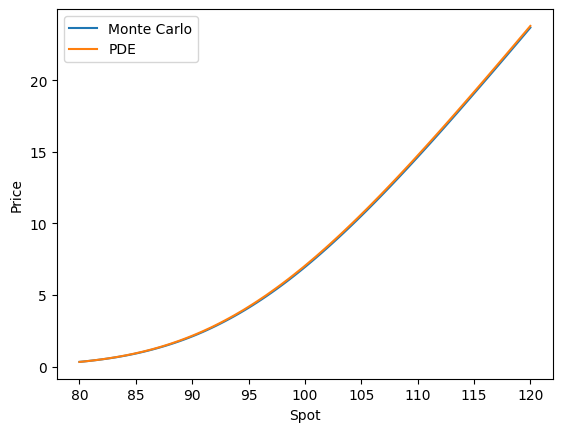

In [85]:
plt.plot(spots, prices_mc, label="Monte Carlo")
plt.plot(spots, prices_pde, label="PDE")
plt.xlabel("Spot")
plt.ylabel("Price")
plt.legend()
plt.show()